# Movie Recomendation System

### 1. Dataset

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

### 2. Preprocess

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

2.1 Load the users and ratings

In [11]:
    def load_data(name):
        df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
        return df

    df1 = load_data('combined_data_1.txt')
    print(df1.shape)

(24058263, 2)


2.2 Watch the rating each user has applied to each movie id

In [12]:
df1.head()

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


2.3 Detecting the movie name of each ID

In [13]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [14]:
movie_id = 1
print(df_title.loc[movie_id].Name)

Dinosaur Planet


In [15]:
movies_ids_df1 = df1.User[df1.Rating.isna()].values
print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


In [16]:
movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
print(movies_ids_df1)

[   1    2    3 ... 4497 4498 4499]


2.5 Create a dataframe with  `User`, `Rating`, `Movie_id` features

In [17]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating))
df1_nan = df1_nan[df1_nan['Rating'] == True]
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids)

[       0      548      694 ... 24056849 24057564 24057834]


In [18]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([ 548,  146, 2013, ...,  715,  270,  429])

In [19]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [20]:
# Agregamos esa columna al dataset y convertimos a tipos de datos que ocupen menos lugar.
df1['Movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['Movie_id'] = df1['Movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

gc.collect()

23

In [21]:
df1.head()

,User,Rating,Movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [22]:
df1.to_csv("combined_data_1_with_movie_id.csv", index= False)

### 3. Dataset Exploration

- How many unique users are there? 

- How many movies did each user rate? 

- How is the distribution of the ratings?

- How is the distribution of the number of ratings per user? 

- What is the film with the most ratings?

In [36]:
df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [37]:
df1.dtypes

User        int64
Rating       int8
Movie_id    int64
dtype: object

Titles

In [27]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


3.1 How many unique users are there? 

In [28]:
print(len(df1['User'].unique()))

470758


3.2 How many movies did each user rate? 

In [29]:
df1_by_users = df1.groupby(['User']).count()
df1_by_users.head()

,Rating,Movie_id
User,,
6,153,153
7,195,195
8,21,21
10,49,49
25,4,4


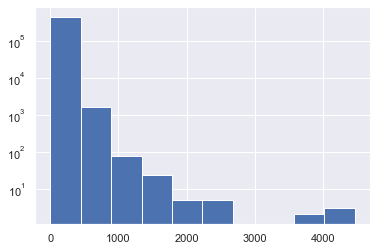

In [30]:
plt.hist(df1_by_users.Rating, log= True)
plt.show()

3.3 How is the distribution of the ratings?


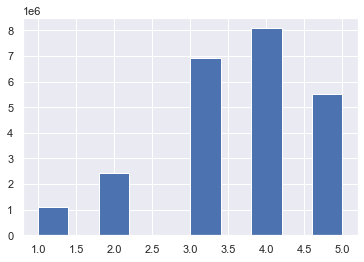

In [31]:
df1['Rating'].hist()
plt.show()

3.4 How is the distribution of the number of ratings per user? 


In [32]:
calificaciones_por_usuario = df1.User.value_counts()
calificaciones_por_usuario

305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
           ... 
791049        1
99015         1
47493         1
119728        1
2355355       1
Name: User, Length: 470758, dtype: int64

<AxesSubplot:>

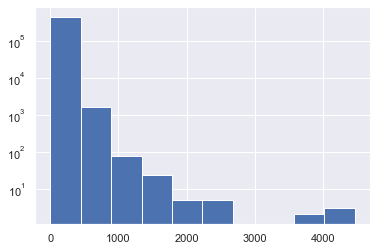

In [33]:
calificaciones_por_usuario.hist(log = True)

3.5 What is the film with the most ratings?

In [34]:
peliculas_por_vistos = df1.Movie_id.value_counts()
peliculas_por_vistos.index = df_title.loc[peliculas_por_vistos.index].Name
peliculas_por_vistos

Name
Pirates of the Caribbean: The Curse of the Black Pearl    193941
What Women Want                                           162597
Bruce Almighty                                            160454
The Italian Job                                           156183
American Beauty                                           154832
                                                           ...  
Ghost Hunters: Season 1                                       44
Haven                                                         43
Expo: Magic of the White City                                 42
Hazaaron Khwaishein Aisi                                      39
Bram Stoker's: To Die For                                     36
Name: Movie_id, Length: 4499, dtype: int64

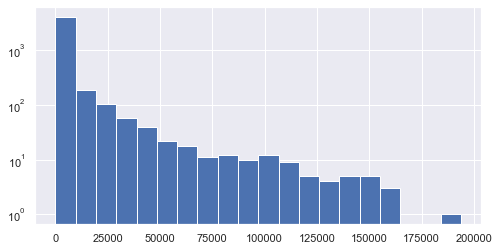

In [35]:
plt.figure(figsize = (8,4))
peliculas_por_vistos.hist(log = True, bins = 20)
plt.show()

### 4. Modeling

4.1 Import Datasets 

In [52]:
df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [53]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


4.2 Surprise Dataset Creation

In [54]:
# surprise no trabaja con datos del dataframe, por lo que debemos pasarlo al formato reader
reader = Reader()

In [55]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'Movie_id', 'Rating']][:N_filas], reader)

4.3 Applying Train/Test Split

In [56]:
# fijarse que en este caso no están separados los targets de los features
trainset, testset = train_test_split(data, test_size=.25)

4.4 SVD Training

In [57]:
# SVD: singular value decomposition (nos hace la partición de matrices U V)
from surprise import SVD
algo = SVD()

In [58]:
# descompongo la matriz original en dos: U, V
algo.fit(trainset)

4.5 Prediction on test set

In [59]:
# en base a las dos matrices creadas, predecimos los los valores aplicandole predicciones al testeset
# U*V 
predictions = algo.test(testset)

In [60]:
# de la librería accuracy traemos rmse para evaluar 
accuracy.rmse(predictions)

RMSE: 1.0536


1.053620050524577

In [61]:
predictions[1]

# uid= usuario
# iid = película
# r_ui = puntuación real
# est = puntuación estimada

Prediction(uid=280677, iid=28, r_ui=4.0, est=3.936754568087769, details={'was_impossible': False})

In [62]:
algo.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.9714695559263835, details={'was_impossible': False})

4.5.1 Movies liked by user 1539350

In [63]:
usuario = 1539350
rating = 5   # le pedimos peliculas a las que haya puesto 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.Movie_id].values
df_user

,User,Rating,Movie_id,Name
0,1539350,5,269,Parenthood
1,1539350,5,270,Sex and the City: Season 4
2,1539350,5,406,Hostage
3,1539350,5,1202,National Lampoon's Vacation
4,1539350,5,2862,The Silence of the Lambs
5,1539350,5,3151,Napoleon Dynamite
6,1539350,5,3605,The Wizard of Oz: Collector's Edition
7,1539350,5,3928,Nip/Tuck: Season 2
8,1539350,5,4159,Barbershop


4.6 Create the recomendations

In [64]:
# creamos una copia con las recomendaciones de usuario
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


4.6.1 Movies the user have seen

In [65]:
# removemos del dataframe todas las películas que ya sabemos que vio
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,Movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


4.6.2 Movies the user have not seen

In [66]:
# eliminamos sobre recomendaciones usuarios (todas las películas), todas las que vió
# nos quedamos todas las películas que no vio
recomendaciones_usuario.drop(usuario_vistas.Movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


4.6.3 Making recomendations

In [67]:
# sobre las películas (x) que no vio el usuario, predice un estimado del ranking que le daría.
# guardamos en nueva columna: Estimate_Score
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [68]:
# ordenamos las películas sugeridas en función de Estimate_Score
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario= recomendaciones_usuario.reset_index(drop=True)
recomendaciones_usuario.head(10)

,Movie_Id,Name,Estimate_Score
0,13,Lord of the Rings: The Return of the King: Ext...,4.445194
1,25,Inspector Morse 31: Death Is Now My Neighbour,4.043184
2,5,The Rise and Fall of ECW,3.974899
3,28,Lilo and Stitch,3.936755
4,18,Immortal Beloved,3.799949
5,1,Dinosaur Planet,3.796845
6,3,Character,3.739101
7,30,Something's Gotta Give,3.718386
8,2,Isle of Man TT 2004 Review,3.649673
9,29,Boycott,3.633164


### 5. Evaluation

In [69]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 1.0536


1.053620050524577

### 6. Hyperparameter Optimization


In [71]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nFactor number: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Factor number: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0424  1.0516  1.0403  1.0447  0.0049  
Fit time          1.06    1.06    1.06    1.06    0.00    
Test time         0.18    0.17    0.18    0.17    0.01    

Factor number: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0477  1.0470  1.0414  1.0454  0.0028  
Fit time          1.04    1.00    0.98    1.01    0.03    
Test time         0.19    0.28    0.30    0.26    0.05    

Factor number: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0455  1.0459  1.0470  1.0461  0.0007  
Fit time          1.21    1.11    1.17    1.16    0.04    
Test time         0.30    0.18    0.34    0.27    0.07    

Factor number: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1

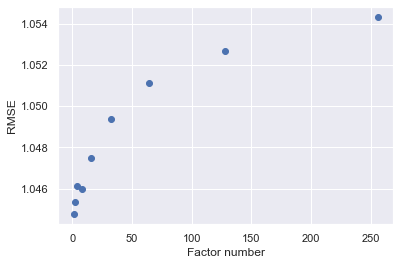

In [73]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Factor number')
plt.ylabel('RMSE')
plt.show()

In [74]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [75]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0458230210169461
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


### 7. Add more records to the dataset

In [76]:
### 1

def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df


df2 = load_data('combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [77]:
### 2.
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [78]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [79]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805])

In [80]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [81]:
df2['Movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['Movie_id'] = df2['Movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

3425

In [82]:
df2

,User,Rating,Movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [83]:
### 4.

df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'Movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [84]:
### 5.

df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


We check that all the movies are

In [14]:
peliculas_presentes = df.Movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int16)

In [15]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


And we save in a file

In [17]:

    df.to_csv('combined_data_1y2_with_movie_id.csv', index= False)

***